In [33]:
import pickle
from pandas import DataFrame
import pandas


pandas.options.mode.copy_on_write = True
pandas.set_option("future.no_silent_downcasting", True)
try:
    with open("data/bloomData.pkl", "rb") as dataPickle:
        fullData: DataFrame = pickle.load(dataPickle, fix_imports=True)
except:
    fullData = DataFrame()

Goals

* [] Temporal Analysis of Cheating Spread
* [] Predictive Modelling of Cheating Risk
* [] Game ownership analysis
* [] Playtime analysis

## Filter to important entries

In [34]:
fullData:DataFrame = fullData.replace({"EconomyBan": {"banned": True, "none": False}}).infer_objects(copy=False)



data:DataFrame = fullData.loc[
    :,
    [
        "communityvisibilitystate",
        "personastate",
        "timecreated",
        "CommunityBanned",
        "NumberOfVACBans",
        "DaysSinceLastBan",
        "NumberOfGameBans",
        "EconomyBan",
        "friendsList",
        "ownedGames",
        "groups",
        "recentlyPlayed",
        "commentpermission",
        "loccountrycode",
        "avatar",
    ],
]

In [35]:
from datetime import date, datetime, timedelta
from math import isnan
import random
from time import localtime

from numpy import number
from pandas import Series, Timedelta

In [36]:
EARLIESTPOSSIBLEBAN = datetime(2003, 9, 12)


def estimatedBans(x):
    numBans: int = x["NumberOfVACBans"] + x["NumberOfGameBans"]

    if numBans == 0:
        return []

    lastBan  = datetime.fromtimestamp(x["LastBanTime"])
    timeCreated: float = x["timecreated"]
    earliestPossibleBan : datetime

    # timeCreated is not available
    #
    # Assumption made:
    #   The criminals activity is spaced based on a normal distribution centred around the last ban time
    if isnan(timeCreated):
        timeSinceLastBan = timedelta(x["DaysSinceLastBan"])
        earliestPossibleBan = max(lastBan - timeSinceLastBan * numBans, EARLIESTPOSSIBLEBAN)
    else:
        earliestPossibleBan = datetime.fromtimestamp(timeCreated)

    banRange = lastBan - earliestPossibleBan
    bans = []

    for i in range(numBans):
        u = random.uniform(0,1)
        bans.append((lastBan - u * banRange).timestamp())

    bans.sort()
    bans.append(lastBan.timestamp())


    return bans

In [37]:
DEFAULT_AVATAR = (
    "https://avatars.steamstatic.com/fef49e7fa7e1997310d705b2a6158ff8dc1cdfeb.jpg"
)

data["MisdemenourCount"] = (
    data["NumberOfVACBans"]
    + data["NumberOfGameBans"]
    + data["CommunityBanned"].apply(lambda b: 1 if b else 0)
    + data["EconomyBan"].apply(lambda b: 1 if b else 0)
)

# Doesn't account for people who doesn't publicize the info
data["ActiveAfterBan"] = data["recentlyPlayed"].apply(
    lambda d: d.get("total_count", 0) > 0
) & (data["NumberOfVACBans"] > 0)

data["HasDefaultAvatar"] = data["avatar"] == DEFAULT_AVATAR
data["WeWereBadButNowWereGood"] = data["DaysSinceLastBan"] > 365

currentTimestamp = datetime.now()
data["LastBanTime"] = data.apply(
    lambda x: (currentTimestamp - timedelta(x["DaysSinceLastBan"])).timestamp() if (x["NumberOfVACBans"] + x["NumberOfGameBans"]) else None #type:ignore
    , axis = 1)

data["averageTimeBetweenBans"] = (
    (data["LastBanTime"] - data["timecreated"])
    / (data["NumberOfVACBans"] + data["NumberOfGameBans"])
).apply(lambda d: None if isnan(d) else d)

data["EstimatedFirstBan"] = data["LastBanTime"] - data["averageTimeBetweenBans"] * (
    (data["NumberOfVACBans"] + data["NumberOfGameBans"]) - 1
)

data["nextBanTime"] = data["LastBanTime"] + data["averageTimeBetweenBans"]

# First time is the creation time
# Any subsequent times are ban times
data["synthesizedTimes"] = data.apply(lambda x : estimatedBans(x), axis = 1) 
data["timecreated"] = data.apply(lambda x : x["synthesizedTimes"][0] if len(x["synthesizedTimes"]) > 0 else None, axis = 1) #type:ignore

data["EstimatedBanTimes"] = data.apply(lambda x : x["synthesizedTimes"][1:] if len(x["synthesizedTimes"]) > 0 else [], axis=1)

We always have information about the latest cheating incident of a particular user, and the amount of time passed since then. We attempt to synthesize the approximate times by assuming that the cheating incidents are evenly spaced between account creation time and the last ban time.

In the event that we do not have information about the creation time of a steam user account, we attempt to synthesize ban intervals using a normal distribution centering on the time since the last ban.

If a non-cheater have an unknown time, then we synthesize the time the account is created using the time of first friendship (because who plays without friends?)
If the friends list isn't public, then we synthesize it using a normal distribution against the population

In [38]:
from math import nan
from typing import Any, cast

import numpy as np


def populateTimeCreatedFromFriends(x: dict[str, Any]):
    timeCreated = x["timecreated"]
    if not isnan(timeCreated):
        return timeCreated

    friendsList = [f["friend_since"] for f in x["friendsList"] if f["friend_since"] != 0]
    if len(friendsList) == 0:
        return nan

    minFriendTime = min(friendsList)
    return minFriendTime


timecreated:Series = data.apply(populateTimeCreatedFromFriends, axis=1).dropna()

validTimeMax = np.max(timecreated)
validTimeMin = np.min(timecreated)
validTimeRange = validTimeMax - validTimeMin

validTimeStdDev = np.std(timecreated)


def populateTimeCreatedFromPopulation(x: dict[str, Any]):
    timeCreated = x["timecreated"]
    if not isnan(timeCreated):
        return timeCreated
    

    return validTimeMin + random.uniform(0,1) * validTimeRange # type:ignore

data["timecreated"] = data.apply(populateTimeCreatedFromPopulation, axis=1)


## Temporal analysis of cheating spread

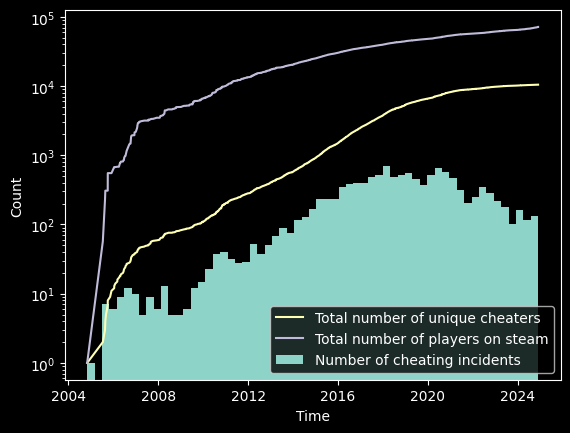

In [43]:


from sys import exception
from matplotlib import legend
import matplotlib.pyplot as plt

cheatingIncidents = []
firstCheatingTimes= []

uniqueCheaters = set()
numUniqueCheaters = []
numPlayers = []

count = 0

for i, e in data.sort_values("timecreated").iterrows(): 
    count+=1
    steamId = i
    banTimes  = e["EstimatedBanTimes"]

    for t in banTimes:
        cheatingIncidents.append((t, i))
        numPlayers.append(count)

    if(len(banTimes) == 0):
        continue
    
    firstCheatingTimes.append(banTimes[0])


cheatingIncidents.sort(key = lambda x : x[0])


cheatingTimes = []
for t in cheatingIncidents:
    cheatingTimes.append(datetime.fromtimestamp(t[0]))
    uniqueCheaters.add(t[1])
    numUniqueCheaters.append(len(uniqueCheaters))



plt.hist(cheatingTimes, log=True, bins="auto")

plt.xlabel("Time")
plt.ylabel("Count")
plt.plot(cheatingTimes,numUniqueCheaters)
plt.plot(cheatingTimes,numPlayers)
plt.legend(["Total number of unique cheaters", "Total number of players on steam", "Number of cheating incidents"])
plt.show()




By plotting the number of cheaters